In [1]:
import numpy as np 
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator , load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os 

In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3


In [5]:
#Prepare Traning Data
filenames = os.listdir("train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
        
df = pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [8]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [9]:
df.tail()

,filename,category
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


<AxesSubplot:>

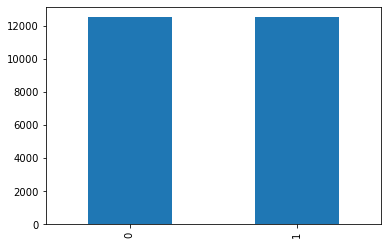

In [10]:
df['category'].value_counts().plot.bar()

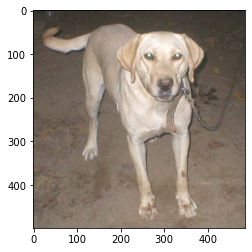

In [55]:
sample = random.choice(filenames)
image = load_img("train/"+sample)
plt.imshow(image)


In [56]:
#Model Build 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
model = Sequential([
    Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    #First Layer Ended
    Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    #Second Layer Ended
    Conv2D(128,(3,3),activation ='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    #Third Layer Ended
    #Feature Extraction Ended
    #Then The Classifier
    Flatten(),
    Dense(512,activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(2,activation='softmax'),#CAT AND DOG
])

In [57]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_19 (Bat  (None, 126, 126, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 63, 63, 32)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_20 (Bat  (None, 61, 61, 64)      

In [58]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


In [59]:
callbacks = [earlystop, learning_rate_reduction]

In [60]:
df['category'] = df['category'].replace({0:'cat',1:'dog'})

In [61]:
train_df , validate_df = train_test_split(df,test_size=0.20,random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

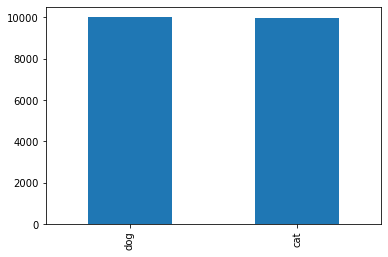

In [62]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

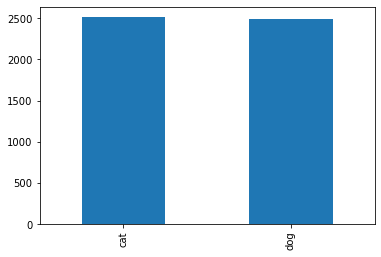

In [63]:
validate_df['category'].value_counts().plot.bar()

In [64]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15


In [65]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)


Found 20000 validated image filenames belonging to 2 classes.


In [66]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)


Found 5000 validated image filenames belonging to 2 classes.


In [67]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)


Found 1 validated image filenames belonging to 1 classes.


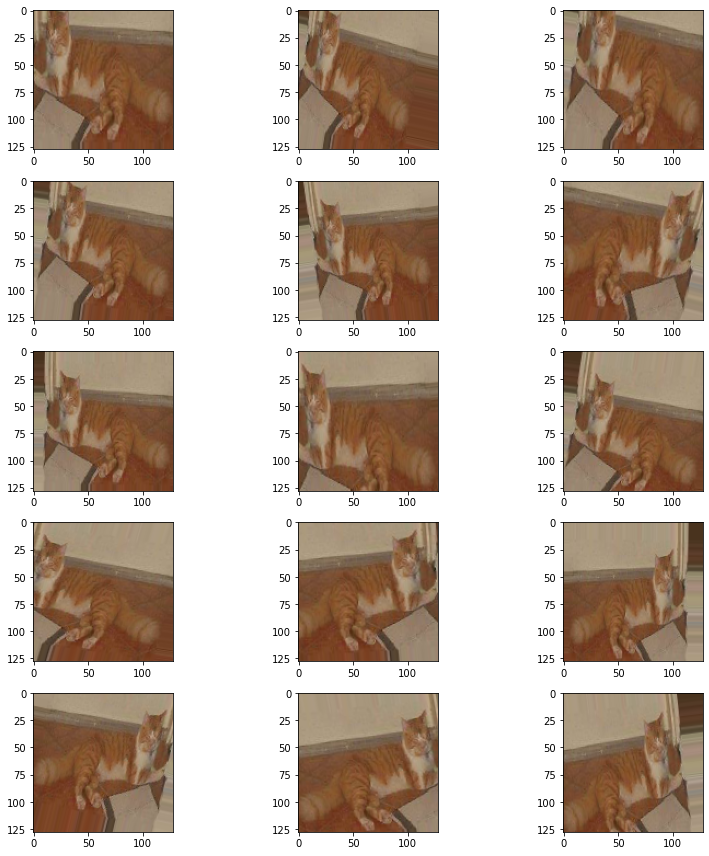

In [68]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()


In [70]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=1,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)


<ipython-input-70-fc2ddba1a2af>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


1333/1333 [==============================] - 722s 541ms/step - loss: 0.6163 - accuracy: 0.6805 - val_loss: 0.5398 - val_accuracy: 0.7381 - lr: 0.0010


In [71]:
model.save_weights("model.h5")
